## Capstone Project: Prediksi Cuaca Sederhana Berbasis Data Historis dengan Machine Learning dan Visualisasi Web

**ID Team:** CC25-CR363

### 📊 Deskripsi Dataset

**Sumber**: [BMKG (Badan Meteorologi, Klimatologi, dan Geofisika)](https://dataonline.bmkg.go.id/)

**Periode Data**: Tahun **2013 hingga 2024**  
**Provinsi**: DKI Jakarta  
**Kota**: Jakarta Pusat  
**Stasiun**: Stasiun Meteorologi Kemayoran

Dataset ini berisi data pengamatan cuaca harian yang dikumpulkan oleh BMKG dari Stasiun Meteorologi Kemayoran. Data mencakup parameter-parameter penting seperti:

- Suhu minimum, maksimum, dan rata-rata (°C)
- Kelembaban rata-rata (%)
- Curah hujan harian (mm)
- Lama penyinaran matahari (jam)
- Kecepatan dan arah angin maksimum serta rata-rata

### 🎯 Tujuan Proyek

Membangun model machine learning untuk memprediksi **kondisi cuaca harian** di Jakarta Pusat berdasarkan data historis. Label cuaca diklasifikasikan menjadi:

## 1. Import Library

In [1]:
pip install imbalanced-learn

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import joblib

## 2. Data Preparation

In [4]:
# Load dataset dari GitHub
url = 'https://raw.githubusercontent.com/melshitaardia/Weather-Prediction/main/datacuaca_BMKG.csv'
df = pd.read_csv(url)

# Tampilkan 5 data teratas
df.head()

,tanggal,temp_min_c,temp_max_c,temp_avg_c,humidity_avg_percent,precip_mm,sunshine_duration_hours,wind_speed_max_ms,wind_dir_max_deg,wind_speed_avg_ms,wind_dir_common_deg,source_file
0,2013-01-01,24.0,31.8,26.2,91.0,1.7,3.5,6,310,3,NW,laporan_iklim_harian-250525120910.xlsx
1,2013-02-01,25.0,31.4,27.9,79.0,0.0,1.2,4,300,3,NW,laporan_iklim_harian-250525120910.xlsx
2,2013-03-01,26.0,32.6,28.6,79.0,1.3,3.5,5,320,4,NW,laporan_iklim_harian-250525120910.xlsx
3,2013-04-01,25.0,30.2,26.3,86.0,34.4,0.4,9,270,5,W,laporan_iklim_harian-250525120910.xlsx
4,2013-05-01,24.0,30.8,26.6,82.0,6.4,4.8,7,270,4,W,laporan_iklim_harian-250525120910.xlsx


## 3. Data Preprocessing

In [5]:
# Buat label cuaca
def generate_label(precip):
    if precip <= 0.2:
        return "cerah"
    elif precip <= 1.0:
        return "mendung"
    else:
        return "hujan"

df['cuaca'] = df['precip_mm'].apply(generate_label)

In [6]:
df_cleaned = df.drop(columns=['tanggal', 'source_file', 'wind_dir_common_deg'])
label_encoder = LabelEncoder()
df_cleaned['cuaca_encoded'] = label_encoder.fit_transform(df_cleaned['cuaca'])

X = df_cleaned.drop(columns=['cuaca', 'cuaca_encoded'])
y = df_cleaned['cuaca_encoded']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Data splitting

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### Balancing (SMOTE)

In [8]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## 5. Modeling

### Random Forest Classifier

In [9]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_smote, y_train_smote)

rf_pred = rf_clf.predict(X_test)

### KNN

In [10]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_smote, y_train_smote)

knn_pred = knn_clf.predict(X_test)

### XGBoost Classifier

In [11]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_smote, y_train_smote)

xgb_pred = xgb_clf.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:01:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### MLPClassifier

In [12]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=200, alpha=0.0001,
                        solver='adam', random_state=42)
mlp_clf.fit(X_train_smote, y_train_smote)

mlp_pred = mlp_clf.predict(X_test)

### TensorFlow MLP (Deep Learning)

In [13]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_smote.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 kelas
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Prediksi TensorFlow model
tf_pred_probs = model.predict(X_test)
tf_pred_classes = tf.argmax(tf_pred_probs, axis=1).numpy()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5014 - loss: 0.9681 - val_accuracy: 0.7346 - val_loss: 0.6301
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7028 - loss: 0.6744 - val_accuracy: 0.7654 - val_loss: 0.5413
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7652 - loss: 0.5717 - val_accuracy: 0.7808 - val_loss: 0.4845
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7883 - loss: 0.5185 - val_accuracy: 0.7750 - val_loss: 0.4803
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7956 - loss: 0.4890 - val_accuracy: 0.7596 - val_loss: 0.5008
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8171 - loss: 0.4587 - val_accuracy: 0.7750 - val_loss: 0.4674
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8257 - loss: 0.4332 - val_accuracy: 0.7712 - val_loss: 0.4634
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8270 - loss: 0.4249 - val_acc

## 6. Evaluation dan Visualization


=== Random Forest ===
              precision    recall  f1-score   support

       cerah       1.00      1.00      1.00       294
       hujan       1.00      0.99      1.00       196
     mendung       0.97      1.00      0.98        30

    accuracy                           1.00       520
   macro avg       0.99      1.00      0.99       520
weighted avg       1.00      1.00      1.00       520



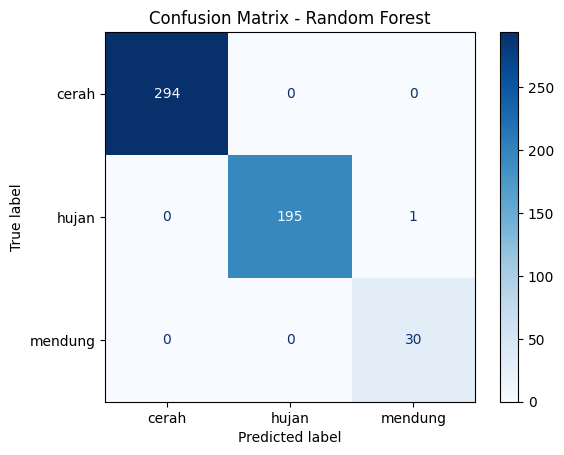


=== XGBoost ===
              precision    recall  f1-score   support

       cerah       1.00      1.00      1.00       294
       hujan       1.00      0.99      1.00       196
     mendung       0.97      1.00      0.98        30

    accuracy                           1.00       520
   macro avg       0.99      1.00      0.99       520
weighted avg       1.00      1.00      1.00       520



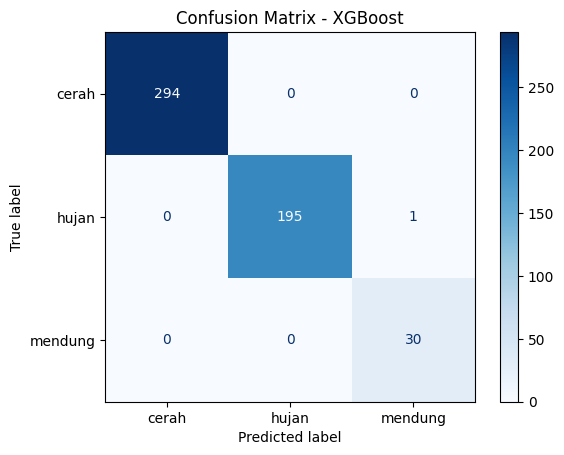


=== KNN ===
              precision    recall  f1-score   support

       cerah       0.87      0.75      0.80       294
       hujan       0.82      0.70      0.75       196
     mendung       0.11      0.37      0.17        30

    accuracy                           0.71       520
   macro avg       0.60      0.60      0.58       520
weighted avg       0.81      0.71      0.75       520



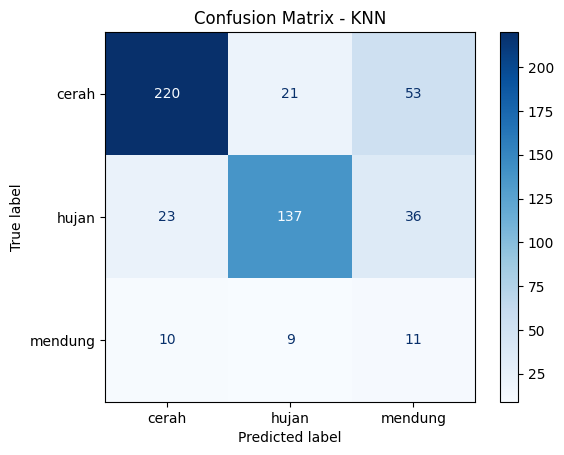


=== MLP Sklearn ===
              precision    recall  f1-score   support

       cerah       0.98      0.99      0.98       294
       hujan       1.00      0.98      0.99       196
     mendung       0.78      0.83      0.81        30

    accuracy                           0.98       520
   macro avg       0.92      0.93      0.93       520
weighted avg       0.98      0.98      0.98       520



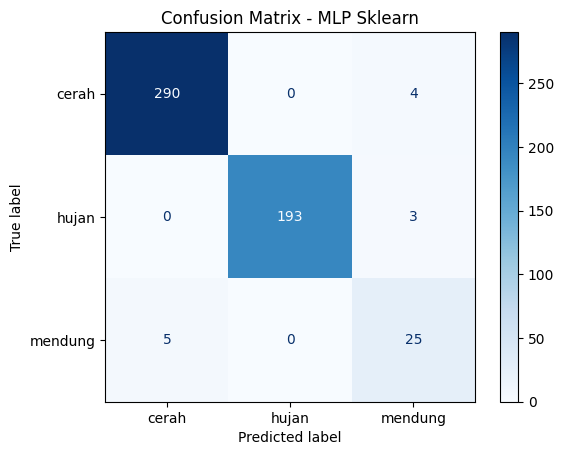


=== MLP TensorFlow ===
              precision    recall  f1-score   support

       cerah       0.99      1.00      0.99       294
       hujan       0.98      0.99      0.99       196
     mendung       0.92      0.80      0.86        30

    accuracy                           0.98       520
   macro avg       0.97      0.93      0.95       520
weighted avg       0.98      0.98      0.98       520



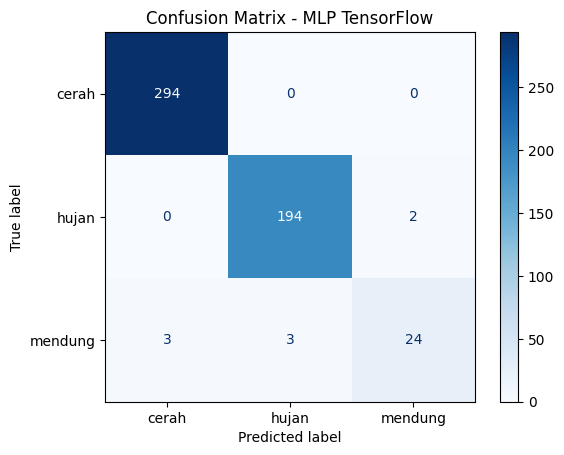

In [14]:
# List semua model prediksi
model_names = ['Random Forest', 'XGBoost', 'KNN', 'MLP Sklearn', 'MLP TensorFlow']
predictions = [rf_pred, xgb_pred, knn_pred, mlp_pred, tf_pred_classes]

# Confusion Matrix dan Classification Report
for name, pred in zip(model_names, predictions):
    print(f"\n=== {name} ===")
    print(classification_report(y_test, pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

## 7. Menentukan Best Model

### 7.1 Bandingkan Performa Model



,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.998077,0.989247,0.998299,0.993683
1,XGBoost,0.998077,0.989247,0.998299,0.993683
2,KNN,0.707692,0.599975,0.604649,0.576146
3,MLP Sklearn,0.976923,0.921434,0.934807,0.927820
4,MLP TensorFlow,0.984615,0.965916,0.929932,0.946448


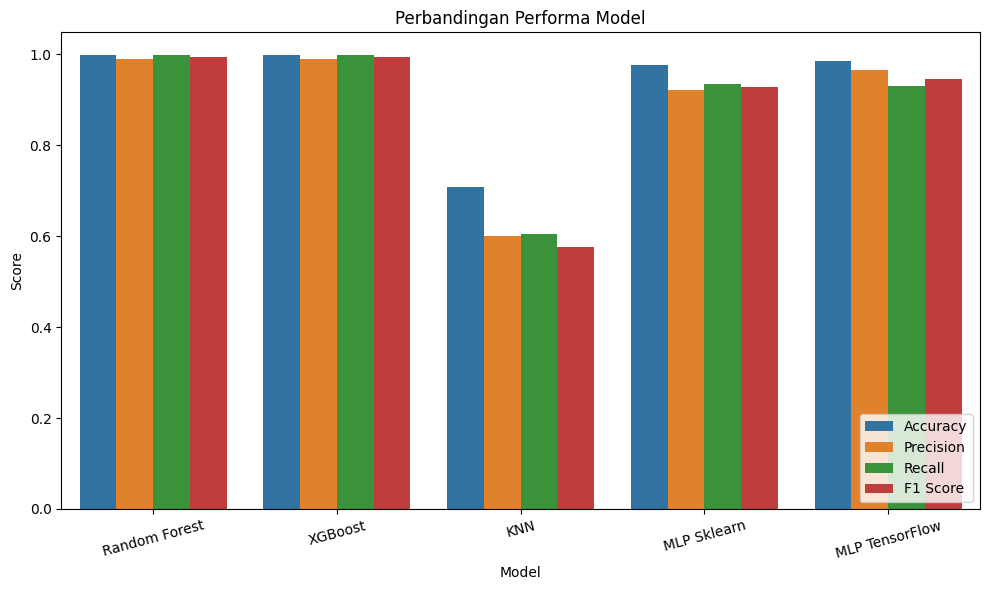

In [15]:
# Buat fungsi evaluasi
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'F1 Score': f1_score(y_true, y_pred, average='macro')
    }

# Evaluasi semua model
results = []
results.append(evaluate_model('Random Forest', y_test, rf_pred))
results.append(evaluate_model('XGBoost', y_test, xgb_pred))
results.append(evaluate_model('KNN', y_test, knn_pred))
results.append(evaluate_model('MLP Sklearn', y_test, mlp_pred))
results.append(evaluate_model('MLP TensorFlow', y_test, tf_pred_classes))

# Tabel hasil
import pandas as pd
results_df = pd.DataFrame(results)
display(results_df)

# Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=results_melted, x="Model", y="Score", hue="Metric")
plt.title("Perbandingan Performa Model")
plt.xticks(rotation=15)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 7.2 Diagnosa Overfitting / Underfitting

Random Forest
Train Accuracy: 1.0
Test Accuracy : 0.9980769230769231

XGBoost
Train Accuracy: 1.0
Test Accuracy : 0.9980769230769231

KNN
Train Accuracy: 0.8243298969072165
Test Accuracy : 0.7076923076923077

MLP Sklearn
Train Accuracy: 1.0
Test Accuracy : 0.9769230769230769


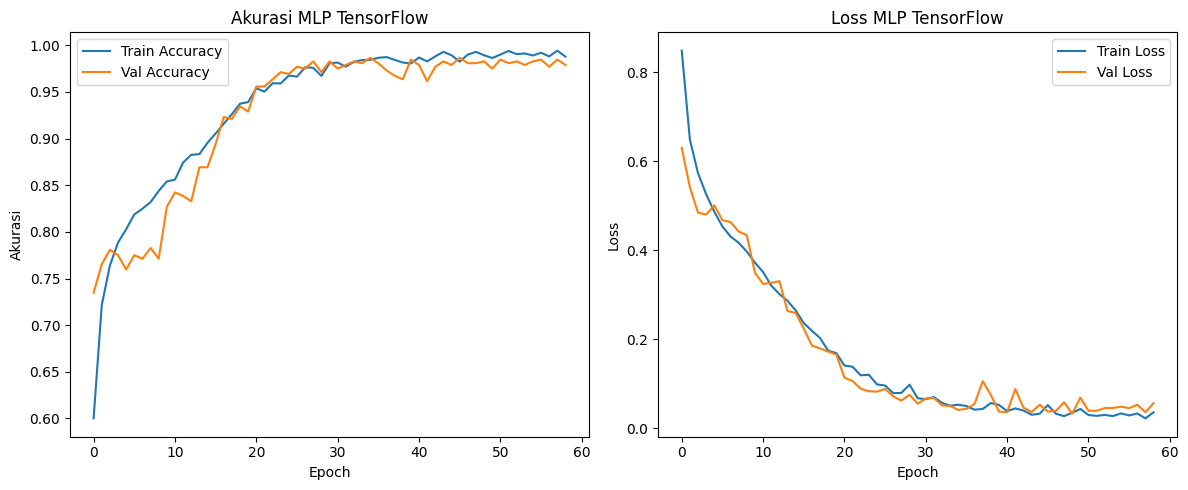

In [16]:
# Akurasi training vs testing (untuk Sklearn models)
print("Random Forest")
print("Train Accuracy:", accuracy_score(y_train, rf_clf.predict(X_train)))
print("Test Accuracy :", accuracy_score(y_test, rf_pred))

print("\nXGBoost")
print("Train Accuracy:", accuracy_score(y_train, xgb_clf.predict(X_train)))
print("Test Accuracy :", accuracy_score(y_test, xgb_pred))

print("\nKNN")
print("Train Accuracy:", accuracy_score(y_train, knn_clf.predict(X_train)))
print("Test Accuracy :", accuracy_score(y_test, knn_pred))

print("\nMLP Sklearn")
print("Train Accuracy:", accuracy_score(y_train, mlp_clf.predict(X_train)))
print("Test Accuracy :", accuracy_score(y_test, mlp_pred))

# Plot training history untuk TensorFlow
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi MLP TensorFlow')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss MLP TensorFlow')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 7.3 Hyperparameter Tuning

In [17]:
# Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf_clf, rf_params, cv=3, scoring='f1_macro', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best Random Forest Params:", rf_grid.best_params_)
print("Best RF Score:", rf_grid.best_score_)

# XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1]
}
xgb_grid = GridSearchCV(xgb_clf, xgb_params, cv=3, scoring='f1_macro', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best XGB Score:", xgb_grid.best_score_)

# KNN
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(knn_clf, knn_params, cv=3, scoring='f1_macro', n_jobs=-1)
knn_grid.fit(X_train, y_train)
print("Best KNN Params:", knn_grid.best_params_)
print("Best KNN Score:", knn_grid.best_score_)

Best Random Forest Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best RF Score: 0.9986234056240919


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:02:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best XGB Score: 0.9986234056240919
Best KNN Params: {'n_neighbors': 3, 'weights': 'distance'}
Best KNN Score: 0.56844554935883


### 8. Konversi Model

In [20]:
# Tentukan model dengan akurasi tertinggi
best_model_row = results_df.sort_values("Accuracy", ascending=False).iloc[0]
best_model_name = best_model_row["Model"]
print(f"\n✅ Model terbaik berdasarkan akurasi: {best_model_name}")

# Simpan model terbaik sesuai jenisnya
if best_model_name == 'Random Forest':
    joblib.dump(rf_clf, "model_best_rf.pkl")
    print("✅ Model Random Forest disimpan sebagai 'model_best_rf.pkl'")

elif best_model_name == 'XGBoost':
    joblib.dump(xgb_clf, "model_best_xgb.pkl")
    print("✅ Model XGBoost disimpan sebagai 'model_best_xgb.pkl'")

elif best_model_name == 'KNN':
    joblib.dump(knn_clf, "model_best_knn.pkl")
    print("✅ Model KNN disimpan sebagai 'model_best_knn.pkl'")

elif best_model_name == 'MLP Sklearn':
    joblib.dump(mlp_clf, "model_best_mlp.pkl")
    print("✅ Model MLP Sklearn disimpan sebagai 'model_best_mlp.pkl'")

elif best_model_name == 'MLP TensorFlow':
    # Simpan model TensorFlow
    model.save("model_best_tf.h5")
    print("✅ Model MLP TensorFlow disimpan sebagai 'model_best_tf.h5'")

    # Konversi ke TFLite juga
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open("model_best_tf.tflite", "wb") as f:
        f.write(tflite_model)
    print("✅ Model TensorFlow juga dikonversi ke 'model_best_tf.tflite'")

joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
print("✅ Scaler dan Label Encoder disimpan.")


✅ Model terbaik berdasarkan akurasi: Random Forest
✅ Model Random Forest disimpan sebagai 'model_best_rf.pkl'
✅ Scaler dan Label Encoder disimpan.


## 9. Inference

In [19]:
# Menggunakan indexing NumPy biasa karena X_test adalah numpy.ndarray
sample_hujan = X_test[y_test == label_encoder.transform(['hujan'])[0]][0]
sample_mendung = X_test[y_test == label_encoder.transform(['mendung'])[0]][0]
sample_cerah = X_test[y_test == label_encoder.transform(['cerah'])[0]][0]

samples = pd.DataFrame([sample_hujan, sample_mendung, sample_cerah])
samples.reset_index(drop=True, inplace=True)

# Prediksi
pred_probs = model.predict(samples)
pred_classes = tf.argmax(pred_probs, axis=1).numpy()
pred_labels = label_encoder.inverse_transform(pred_classes)

# Tampilkan hasil
print("Hasil Inference:")
for i, label in enumerate(['Hujan', 'Mendung', 'Cerah']):
    print(f"Data Sampel: {label}")
    print(f"Prediksi: {pred_labels[i]}")
    print(f"Probabilitas: {pred_probs[i]}")
    print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Hasil Inference:
Data Sampel: Hujan
Prediksi: hujan
Probabilitas: [0. 1. 0.]
------------------------------
Data Sampel: Mendung
Prediksi: mendung
Probabilitas: [0.00325802 0.0120551  0.9846869 ]
------------------------------
Data Sampel: Cerah
Prediksi: cerah
Probabilitas: [9.999999e-01 7.913356e-11 6.395144e-08]
------------------------------
